## Word Cloud and Word Frequency

Here we look into the most frequent words in the subject line and content of the emails.

The dataframe has been cleaned in the previous sections and is ready to work with.

It is a good idea to remove stop words from the data for producing a wordcloud and numeric word frequency. For stop words I used ENGLISH_STOP_WORDS from sklearn which contains 318 stop words. 

P.S. There is another common stop word list from NLTK which contains 179 words (from nltk.corpus import stopwords >> stopwords.words('english'))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
import seaborn as sns
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from collections import Counter

In [2]:
df = pd.read_csv('out.csv', index_col='Message-ID', parse_dates=['Date'], infer_datetime_format=True, low_memory=False)
print('Dataframe is ready.')

Dataframe is ready.


### Word cloud for the subject field

The elements in the Subject column are strings unless the subject field was left empty. In that case they are float nan. In order to join the subject fields first we need to convert the float values to string. But by doing so nan would be counted as a word. I will keep the nan values and see if they appear in the wordcloud figure.

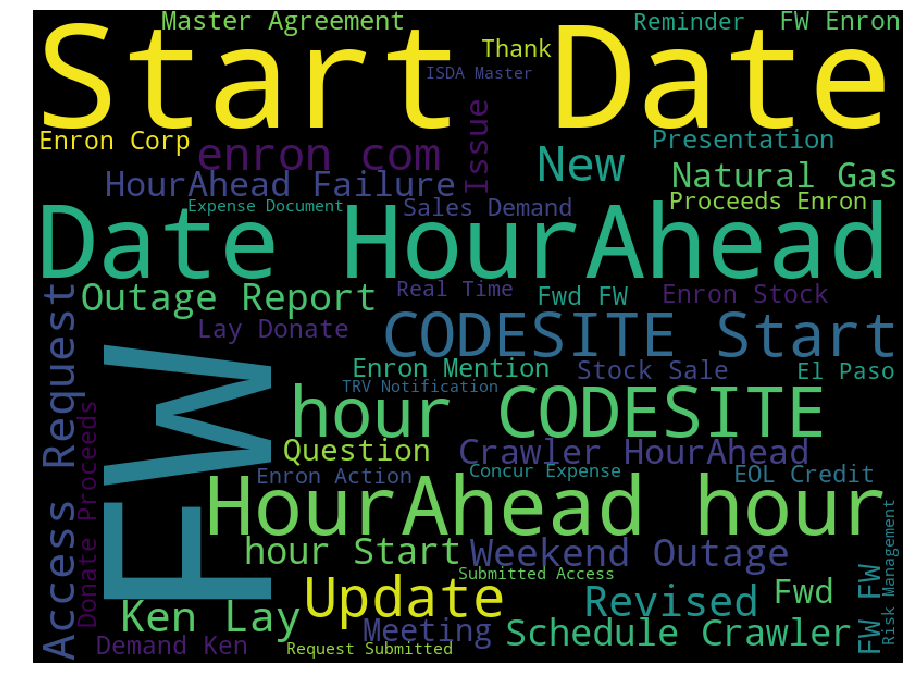

In [3]:
df['Subject'] = df['Subject'].fillna('') 

subjects = ' '.join(df['Subject'])

fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=50,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
_ = ax.imshow(wc)
_ = ax.axis("off")

- Wordcloud contains repeated words which is disappointing. The idea of a wordcloud is to show the words that appear more frequently in the source text with a larger font. 

### Word cloud for the content (from 1000 sampled emails)

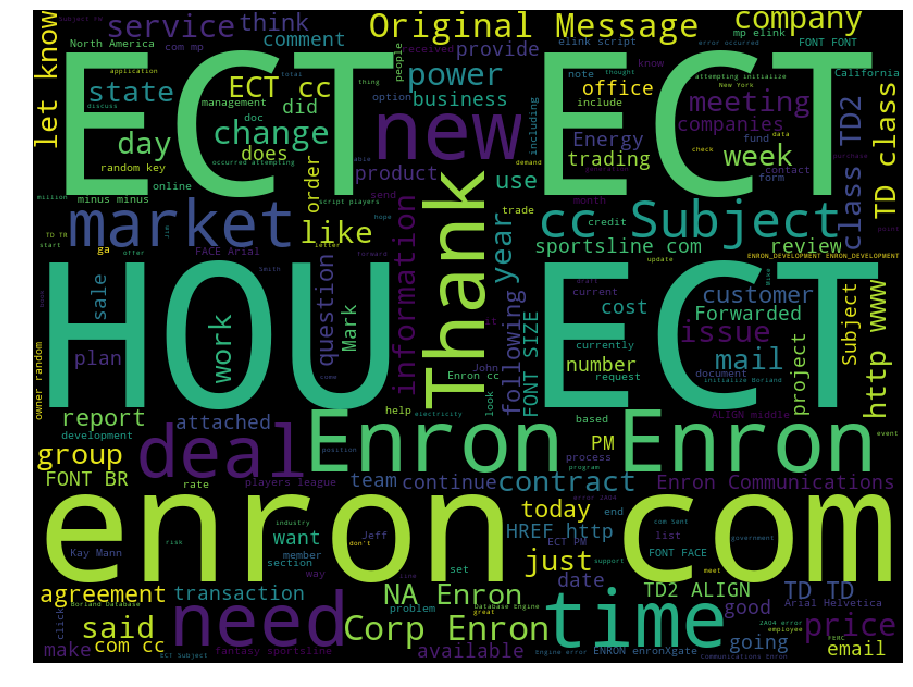

In [4]:
contents = ' '.join(df.sample(1000)['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
_ = ax.imshow(wc)
_ = ax.axis("off")

## Word Frequency in the Subject Field
What were the most frequent words in the subject line of the emails? What are their exact order and count?

In [5]:
# What are the most common subject lines?
df.groupby('Subject')['Subject'].count().sort_values(ascending=False)[:10]

Subject
                                                         19187
RE:                                                       6477
Re:                                                       6306
Demand Ken Lay Donate Proceeds from Enron Stock Sales     1124
FW:                                                        938
Schedule Crawler: HourAhead Failure                        900
Schedule Crawler: HourAhead Failure <CODESITE>             800
Enron Mentions                                             784
EnTouch Newsletter                                         518
Organizational Announcement                                378
Name: Subject, dtype: int64

In [6]:
# drop the emails with no subject line
df = df[df['Subject'] != 'nan']
# df.dropna(subset=['Subject'], axis=0, inplace=True) would work if we have not converted the column to str.

In [7]:
# Counting the most frequent words in the subject field before tokenization.
# It is necessary to convert the characters to lowercase.
pd.Series(' '.join(df['Subject']).lower().split()).value_counts()[:10]

re:      155258
-         46779
for       41915
fw:       39043
of        26700
and       24916
to        24094
the       20111
enron     18809
on        15863
dtype: int64

In [8]:
# Alternatively we can use Counter from the collection module to count the most frequent words
Counter(" ".join(df['Subject']).lower().split()).most_common(10)

[('re:', 155258),
 ('-', 46779),
 ('for', 41915),
 ('fw:', 39043),
 ('of', 26700),
 ('and', 24916),
 ('to', 24094),
 ('the', 20111),
 ('enron', 18809),
 ('on', 15863)]

In [9]:
# Tekenization will change the above results.
# The following list will not contain nan values.
subjects = ' '.join(df['Subject'])
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
subjects_tokens = tokenizer.tokenize(subjects) # class: list
print('Number of total tokens in the subject line of over 500000 emails:', len(subjects_tokens))

Number of total tokens in the subject line of over 500000 emails: 2309634


In [10]:
# lowercase the tokens 
subjects_tokens = list(map(str.lower,subjects_tokens))

In [11]:
Counter(subjects_tokens).most_common(10) # class collections.Counter

[('re', 158476),
 ('for', 42112),
 ('fw', 39154),
 ('of', 26839),
 ('and', 25052),
 ('to', 24624),
 ('enron', 24307),
 ('01', 21352),
 ('the', 20513),
 ('meeting', 16373)]

We need to remove the stop words from the tokenized list. It will be much faster to groupby tokens first and then eliminate the stop words. Otherwise every token in the list of 2,309,634 tokens has to be checked against stop words. In order to do so a dataframe will be built from the Counter.

In [12]:
# Make a dataframe from the Counter
word_df = pd.DataFrame.from_dict(Counter(subjects_tokens), orient='index').reset_index()
word_df.columns = ['word','count']
word_df.sort_values('count', ascending =False).reset_index(drop=True).head(10)

,word,count
0,re,158476
1,for,42112
2,fw,39154
3,of,26839
4,and,25052
5,to,24624
6,enron,24307
7,01,21352
8,the,20513
9,meeting,16373


In [13]:
# Removing stop words
word_df = word_df[~word_df['word'].isin(ENGLISH_STOP_WORDS)].reset_index(drop=True).sort_values('count', ascending=False)
print(word_df.head(20))

            word  count
10            fw  39154
115        enron  24307
139           01  21352
28       meeting  16373
22          2001  12676
93           new  12070
15           gas  11395
368    agreement  11033
83        report  10883
635       energy  10509
202        power  10302
151       update   9568
10538  hourahead   9069
153           00   8709
575         2000   8600
658         date   8403
89       request   8207
353         hour   8176
686           10   7788
1267       start   7722


Among the most frequent words used in the subject line are '00', '2001, '01', 'agreement', 'meeting',... that were not shown on the word cloud at all or were shown with a relatively small font. In addition to showing repeat words, the word cloud did not do a good job in showing the most frequent words with bigger sizes.

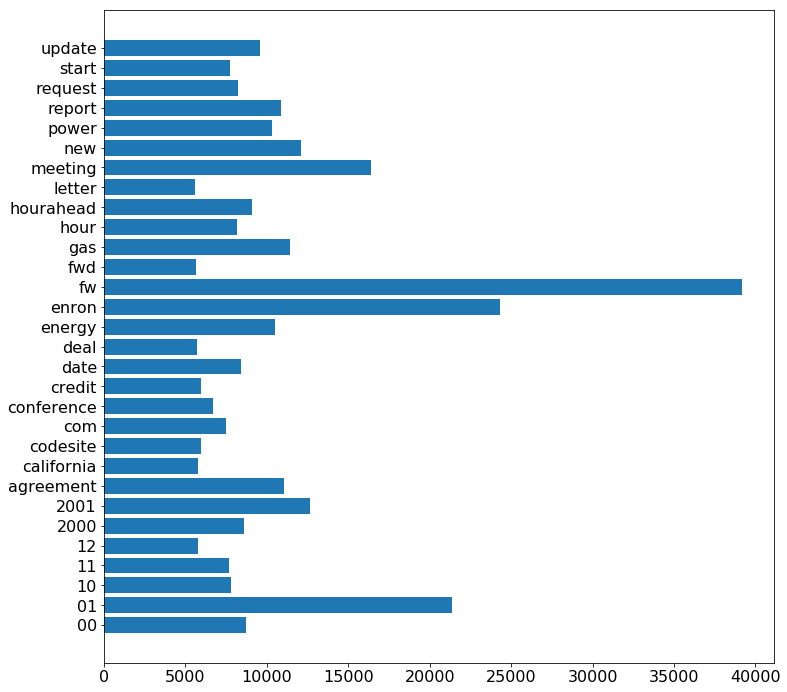

In [14]:
# bar plot, sorted alphabetically
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 12)
ax.barh(word_df.iloc[:30,0], word_df.iloc[:30,1])
ax.tick_params(axis='both', which='major', labelsize=16)

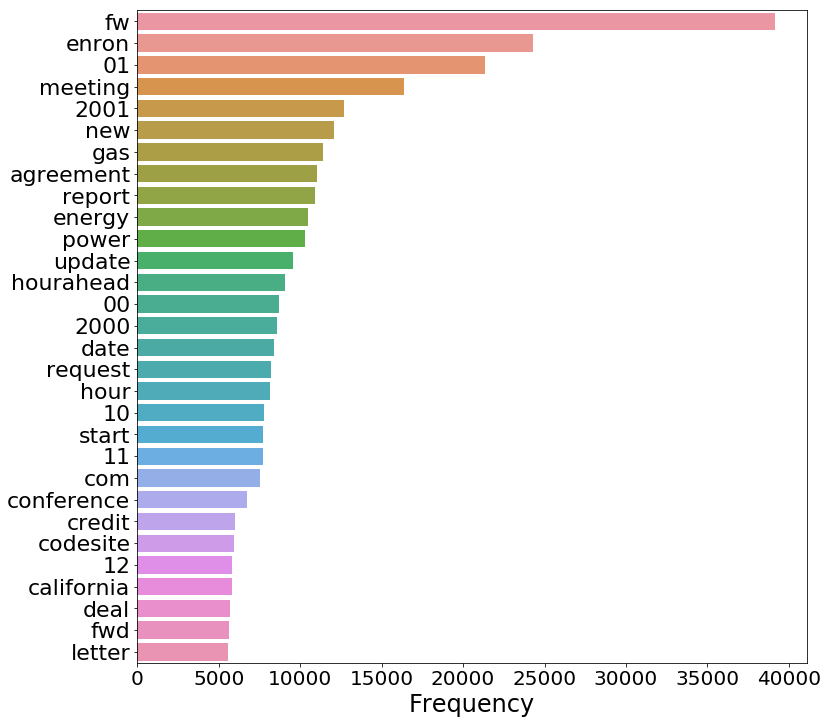

In [15]:
# bar plot with seaborn
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 12)
_ = sns.barplot(x=word_df.iloc[:30,1], y=word_df.iloc[:30,0], ax=ax)
_ = ax.tick_params(axis='x', which='major', labelsize=20)
_ = ax.tick_params(axis='y', which='major', labelsize=22)
_ = ax.set_xlabel('Frequency', fontsize=24)
_ = ax.set_ylabel('')